In [1]:
import scanpy as sc
import os,sys,glob
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
sc.settings.n_jobs = 40
sc.set_figure_params(figsize=(4,4), vector_friendly = True)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [2]:
adata = sc.read_h5ad("Data/Output_240308_adata_scvi_random_sampleID.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 393060 × 49133
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain Region', 'Dataset', 'Sex', 'Diagnosis', 'cluster_original', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', '_scvi_batch', '_scvi_labels', 'leiden_0.6', 'cluster_annotated', 'Leiden', 'Cell Type'
    uns: 'Brain Region_colors', 'Brain_Region_colors', 'Cell Type_colors', 'Stage_colors', 'cluster_annotated_colors', 'leiden_0.6_colors', 'log1p', 'ttest_pts', 'wilcoxon'
    obsm: 'X_scVI_sampleID', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts', 'scaled'

In [4]:
adata.X

In [5]:
adata.obs.columns

Index(['batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI',
       'Hemisphere', 'Library', 'Brain Region', 'Dataset', 'Sex', 'Diagnosis',
       'cluster_original', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'doublet_scores',
       'predicted_doublets', '_scvi_batch', '_scvi_labels', 'leiden_0.6',
       'cluster_annotated', 'Leiden', 'Cell Type'],
      dtype='object')

In [6]:
adata.obs[["Stage", "Age"]].value_counts().sort_index(level=0)

Stage                  Age         
Fetal (1st trimester)  49.000000        3602
                       56.000000        5888
                       60.199999        3101
                       60.899999        6204
                       62.300001       17648
                       63.000000         617
                       70.000000        7942
                       73.500000        1005
                       78.399999        3523
                       84.000000        5750
                       98.000000        6236
                       105.000000       3325
                       112.000000       3267
Fetal (2nd trimester)  115.500000      17033
                       154.000000       9123
                       168.000000       9027
Fetal (3rd trimester)  238.000000       6435
Neonatal               367.000000       9272
                       399.000000       6336
                       451.000000       8042
                       483.000000       3604
                   

In [7]:
adata.obs["Dataset"].value_counts()

Herring     143846
AllenM1      74482
Braun        68108
ZhangPD      33099
Turecki      22124
Morabito     20720
Cameron      17033
Hardwick     13648
Name: Dataset, dtype: int64

In [8]:
# Add "Zhu" and "Nagy" as a category
adata.obs["Dataset"] = adata.obs["Dataset"].cat.add_categories(["Zhu"])
adata.obs["Dataset"] = adata.obs["Dataset"].cat.add_categories(["Nagy"])

adata.obs.loc[adata.obs["Dataset"] == "ZhangPD", "Dataset"] = "Zhu"
adata.obs.loc[adata.obs["Dataset"] == "Turecki", "Dataset"] = "Nagy"

In [9]:
adata.obs["Dataset"].value_counts()

Herring     143846
AllenM1      74482
Braun        68108
Zhu          33099
Nagy         22124
Morabito     20720
Cameron      17033
Hardwick     13648
ZhangPD          0
Turecki          0
Name: Dataset, dtype: int64

In [10]:
# Remove the old dataset categories
adata.obs["Dataset"] = adata.obs["Dataset"].cat.remove_categories(["ZhangPD", "Turecki"])
adata.obs["Dataset"].value_counts()

Herring     143846
AllenM1      74482
Braun        68108
Zhu          33099
Nagy         22124
Morabito     20720
Cameron      17033
Hardwick     13648
Name: Dataset, dtype: int64

In [11]:
sampleID_list1 = ['10X101_3', '10X101_7', '10X102_1', '10X115_5', '10X115_7', '10X116_6', '10X119_2', '10X119_5',
                  '10X156_2', '10X167_8', '10X168_1', '10X168_2', '10X168_5', '10X169_1', '10X169_2', '10X177_4', 
                  '10X178_5', '10X212_5', '10X212_6', '10X213_1', '10X302_1'] 

In [12]:
adata.obs["Sex_impute"] = adata.obs["Sex"].copy()

In [13]:
for idx, row in adata.obs.iterrows():
    # Check if Dataset is 'Braun' and sampleID is in sampleID_list1
    if row['Dataset'] == 'Braun' and row['sampleID'] in sampleID_list1:
        adata.obs.at[idx, 'Sex_impute'] = "F"
    # Check if Dataset is 'Braun' and sampleID is in sampleID_list2
    elif row['Dataset'] == 'Braun' and row['sampleID'] not in sampleID_list1:
        adata.obs.at[idx, 'Sex_impute'] = "M"

In [14]:
adata.obs[["Sex", "Sex_impute"]].value_counts()

Sex      Sex_impute
M        M             184761
F        F             140191
Unknown  M              39071
         F              29037
dtype: int64

In [15]:
adata.obs[["Leiden", "cluster_annotated"]].value_counts()

Leiden  cluster_annotated     
C0      Oligo OPALIN SEPHS1P6     52562
C1      Exc LINC00507 FAM163A     43420
C2      Astro FGFR3 LINC00500     30353
C3      Neuroblast LINC01210      22841
C4      RG HES1 WNT1              21400
C5      Exc RORB TRABD2A          17072
C6      Inh SST TNFSF15           16392
C7      Inh VIP TAC3              15314
C8      Inh PVLAB AKAIN1          15017
C9      OPC PDGFRA GPNMB          13911
C10     Exc RORB IZUMO3           13055
C11     Neuroblast NEUROD6        11350
C12     Exc Fetal STK32B          10525
C13     Micro TYROBP DOCK8         9873
C14     Exc FEZF2 MANCR            9460
C15     Exc LINC00507 C18orf61     8733
C16     Exc FEZF2 GHSR             7555
C17     Exc FEZF2 LINC01479        7493
C18     RG HES1 MRPS33P2           7176
C19     Inh ADARB2 LINC03069       6608
C20     Inh Fetal LIX1L-AS1        6019
C21     Inh LAMP5 CPLX3            4762
C22     Exc RORB REREP3            4677
C23     Inh Fetal LINC02802        4577
C24     N

In [16]:
adata.obs["cluster_annotated"] = np.where(adata.obs["Leiden"] == "C39", "Micro Fetal CCL3L3", adata.obs["cluster_annotated"])
adata.obs["cluster_annotated"] = np.where(adata.obs["Leiden"] == "C38", "Oligo Neonatal ADAM33", adata.obs["cluster_annotated"])

In [17]:
adata.obs[["Leiden", "cluster_annotated"]].value_counts()

Leiden  cluster_annotated     
C0      Oligo OPALIN SEPHS1P6     52562
C1      Exc LINC00507 FAM163A     43420
C2      Astro FGFR3 LINC00500     30353
C3      Neuroblast LINC01210      22841
C4      RG HES1 WNT1              21400
C5      Exc RORB TRABD2A          17072
C6      Inh SST TNFSF15           16392
C7      Inh VIP TAC3              15314
C8      Inh PVLAB AKAIN1          15017
C9      OPC PDGFRA GPNMB          13911
C10     Exc RORB IZUMO3           13055
C11     Neuroblast NEUROD6        11350
C12     Exc Fetal STK32B          10525
C13     Micro TYROBP DOCK8         9873
C14     Exc FEZF2 MANCR            9460
C15     Exc LINC00507 C18orf61     8733
C16     Exc FEZF2 GHSR             7555
C17     Exc FEZF2 LINC01479        7493
C18     RG HES1 MRPS33P2           7176
C19     Inh ADARB2 LINC03069       6608
C20     Inh Fetal LIX1L-AS1        6019
C21     Inh LAMP5 CPLX3            4762
C22     Exc RORB REREP3            4677
C23     Inh Fetal LINC02802        4577
C24     N

In [18]:
adata.obs[["Cell Type", "cluster_annotated"]].value_counts().sort_index(level=0)

Cell Type   cluster_annotated     
Astro       Astro FGFR3 CD44           3110
            Astro FGFR3 LINC00500     30353
Ext         Exc FEZF2 CCDC80-1         3455
            Exc FEZF2 GHSR             7555
            Exc FEZF2 LINC00922        1330
            Exc FEZF2 LINC01479        7493
            Exc FEZF2 MANCR            9460
            Exc Fetal STK32B          10525
            Exc Fetal TAS2R30          2196
            Exc LINC00507 C18orf61     8733
            Exc LINC00507 FAM163A     43420
            Exc RORB IZUMO3           13055
            Exc RORB REREP3            4677
            Exc RORB TRABD2A          17072
            Exc SLC17A SNCB            1300
            Exc THEMIS IL7R            1135
Inh         Inh ADARB2 LINC03069       6608
            Inh Fetal LINC02802        4577
            Inh Fetal LIX1L-AS1        6019
            Inh LAMP5 CPLX3            4762
            Inh LAMP5 NKX2-1           2921
            Inh PVALB NOG              20

In [19]:
adata.obs["Cell Type"] = np.where(adata.obs["Cell Type"] == "Vascular", "Endo", adata.obs["Cell Type"])

In [20]:
adata.obs[["Cell Type", "cluster_annotated"]].value_counts().sort_index(level=0)

Cell Type   cluster_annotated     
Astro       Astro FGFR3 CD44           3110
            Astro FGFR3 LINC00500     30353
Endo        Endo NOSTRIN FOXC2         2095
Ext         Exc FEZF2 CCDC80-1         3455
            Exc FEZF2 GHSR             7555
            Exc FEZF2 LINC00922        1330
            Exc FEZF2 LINC01479        7493
            Exc FEZF2 MANCR            9460
            Exc Fetal STK32B          10525
            Exc Fetal TAS2R30          2196
            Exc LINC00507 C18orf61     8733
            Exc LINC00507 FAM163A     43420
            Exc RORB IZUMO3           13055
            Exc RORB REREP3            4677
            Exc RORB TRABD2A          17072
            Exc SLC17A SNCB            1300
            Exc THEMIS IL7R            1135
Inh         Inh ADARB2 LINC03069       6608
            Inh Fetal LINC02802        4577
            Inh Fetal LIX1L-AS1        6019
            Inh LAMP5 CPLX3            4762
            Inh LAMP5 NKX2-1           29

In [21]:
meta = pd.read_csv("samplemeta.csv")
meta = meta[['SampleID', 'DonorID']]
meta = meta.rename(columns = {'SampleID': 'sampleID',
                              'DonorID': 'donorID'})
meta_obs = adata.obs
meta_merged = pd.merge(meta, adata.obs, on = 'sampleID', how = 'left', left_index=True)
adata.obs = meta_merged

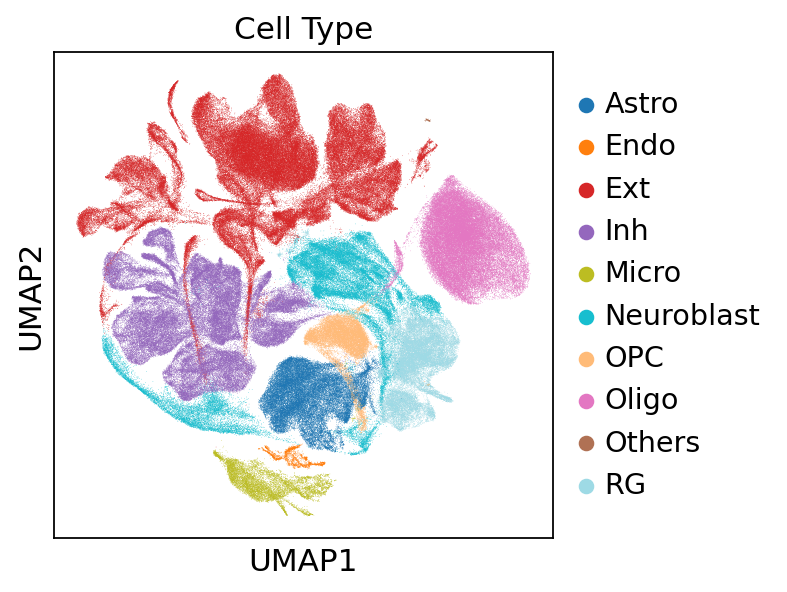

In [22]:
sc.pl.umap(adata, color = "Cell Type")

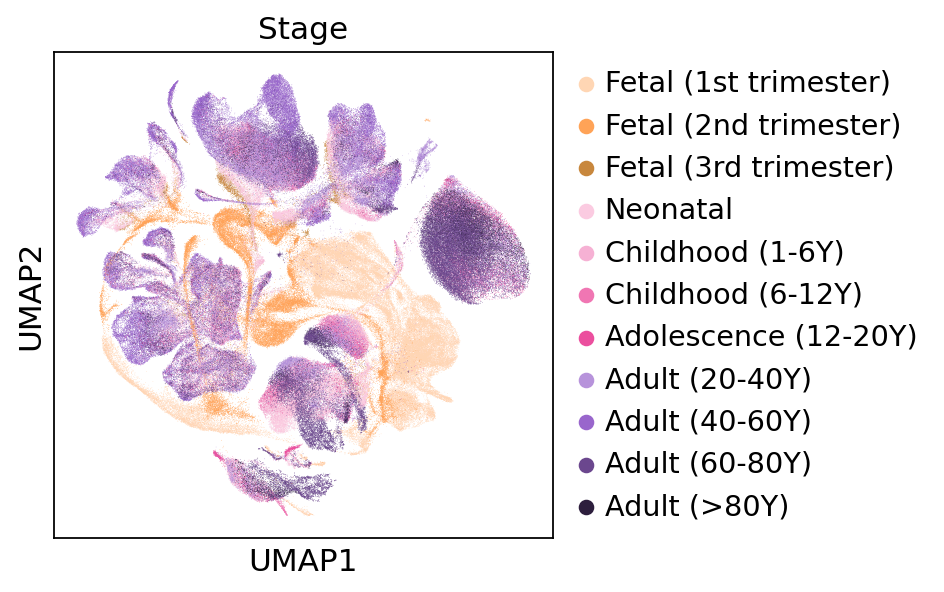

In [23]:
sc.pl.umap(adata, color = "Stage")

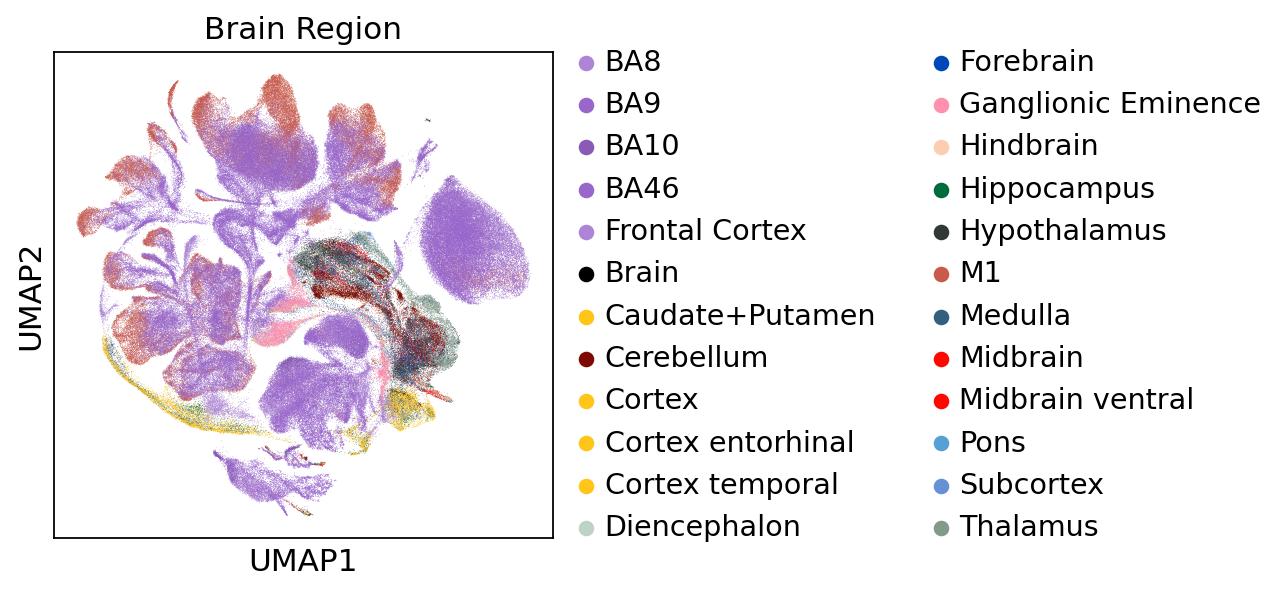

In [24]:
sc.pl.umap(adata, color = "Brain Region")

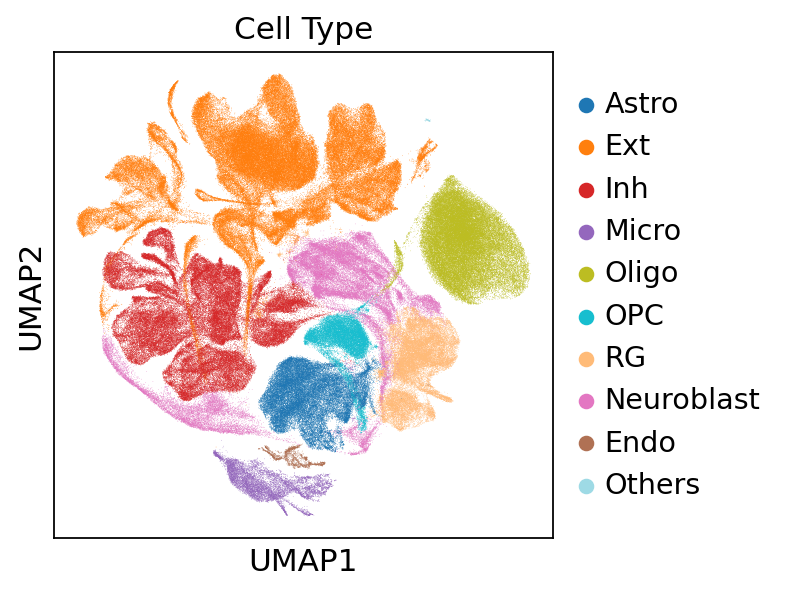

In [25]:
celltype_dict_stage = {
            'Astro': '#1f77b4ff',
            'Ext': '#ff7f0eff',
            'Inh': '#d62728ff',
            'Micro': '#9467bdff',
            'Oligo': '#bcbd22ff',
            'OPC': '#17becfff',
            'RG': '#ffbb78ff',    
            'Neuroblast': '#e377c2ff',
            'Endo': '#b07154',
            'Others': '#9edae5ff',
            }

adata.obs['Cell Type'] = pd.Categorical(adata.obs['Cell Type'], categories=celltype_dict_stage.keys(), ordered=True)

sc.pl.umap(adata, color='Cell Type', palette=celltype_dict_stage)

In [26]:
adata.write_h5ad("Data/Output_240327_adata_scvi_random_sampleID.h5ad")